In [1]:
%pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=3da70ce2389a89c64473af277e13e582a44f288abf1115702ee62d116283b67a
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [2]:
import pyod
import numpy as np
import matplotlib.pyplot as plt
import typing as t
import keras
import tensorflow as tf

from keras import layers
from keras import ops
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from pyod.models.pca import PCA
from pyod.models.kpca import KPCA

In [3]:
from sklearn.metrics import confusion_matrix

class Metrics:
    @staticmethod
    def balanced_accuracy(labels: np.ndarray, predictions: np.ndarray) -> float:
        tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

        # compute recall, sensitivity
        tpr = tp / (tp + fn)
        # compute specificity
        tnr = tn / (tn + fp)
        # compute balanced accuracy
        ba = (tpr + tnr) / 2

        return ba

# **Exercise 1:**

1. In the first exercise you will generate a 3D dataset with 500 points using **np.random.multivariate_normal** function with the mean vector **[5, 10,
2]** and the covariance matrix **[[3, 2, 2], [2, 10, 1], [2, 1, 2]]** and plot it
(3D). Then you will perform the PCA steps from the course (center data,
compute covariance matrix, EVD).

2. Plot in the same figure both the cumulative explained variance (computed with the sorted [descending] eigenvalues and the numpy.cumsum
function) with the **pyplot.step** function and the individual variances (respecting the order) - using the **pyplot.bar** function.

3. Project the data in the new space and identify the outliers based on the deviation of the values over the dimension corresponding to the 3rd principal
component (compared to the mean of all the values of the same component). Use **0.1** as contamination rate and the numpy.quantile function
in order to find the corresponding threshold and predict the labels. Plot
the dataset again (using a different color for points labeled as anomalies).
Repeat the same steps for the second principal component.

4. Project the data in the new space and identify the outliers based on the
normalized distance (by the corresponding standard deviation) of the data
points to the centroid (in the new space) along all the principal components
(follow the steps from the algorithm in the first part of the lab). Plot the
dataset again (using a different color for points labeled as anomalies)

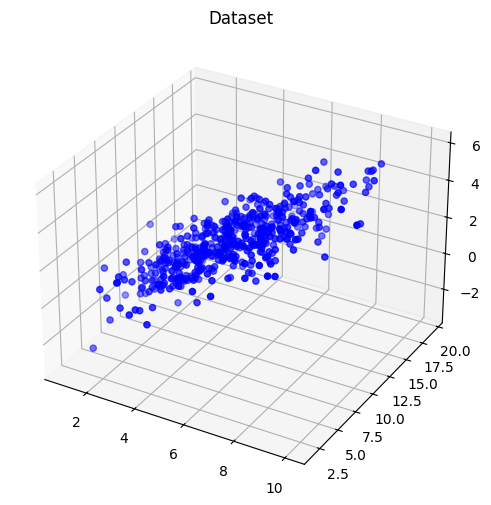

In [ ]:
dataset = np.random.multivariate_normal(mean=[5, 10, 2], cov=[[3, 2, 2], [2, 10, 1], [2, 1, 2]], size=500)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], color="blue")
ax.set_title("Dataset")
plt.show()

In [ ]:
def pca(X: np.ndarray) -> t.List[np.ndarray]:
  # divide by N, the number of samples
  Σ = X * (1 / X.shape[0])
  # compute the covariance matrix
  Σ = np.dot(Σ.T, Σ)
  eigenvalues, eigenvectors = np.linalg.eigh(Σ)

  # get the index of the descending eigenvalues
  idx = np.argsort(eigenvalues)[::-1]
  # sort the eigenvalues vector and eigenvectors matrix accordingly
  eigenvalues = eigenvalues[idx]
  eigenvectors = eigenvectors[:, idx]

  return [eigenvalues, eigenvectors]

dataset = dataset - np.mean(dataset, axis=0)
dataset_eigenvalues, dataset_eigenvectors = pca(dataset)
print(f"Eigenvalues of the dataset: {dataset_eigenvalues}")

Eigenvalues of the dataset: [0.02173305 0.00684484 0.00083599]


Text(0.5, 1.0, 'Individual variances')

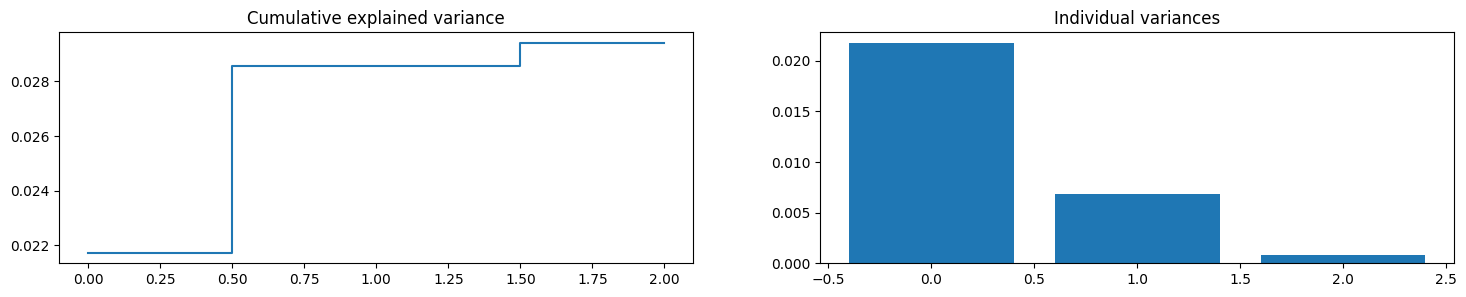

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 3))
indexes = [i for i in range(len(dataset_eigenvalues))]

axs[0].step(range(len(dataset_eigenvalues)), np.cumsum(dataset_eigenvalues), where="mid")
axs[0].set_title("Cumulative explained variance")

axs[1].bar(range(len(dataset_eigenvalues)), dataset_eigenvalues)
axs[1].set_title("Individual variances")

In [ ]:
def get_labels(
  dataset: np.ndarray,
  dataset_eigenvectors: np.ndarray,
  component: int = 0,
  contamination_rate: float = 0.1
) -> np.ndarray:
  # project the dataset using the 3rd principal component
  dataset_proj = dataset @ dataset_eigenvectors[component]

  # label the data based on its distance from the mean,
  # using a quantile of contamination rate of 0.1
  dataset_proj = abs(dataset_proj - np.mean(dataset_proj))
  dataset_proj_quantile = np.quantile(dataset_proj, 1 - contamination_rate)
  dataset_proj_labels = np.where(dataset_proj > dataset_proj_quantile, 1, 0)

  return dataset_proj_labels

Text(0.5, 0.92, '3RD COMPONENT')

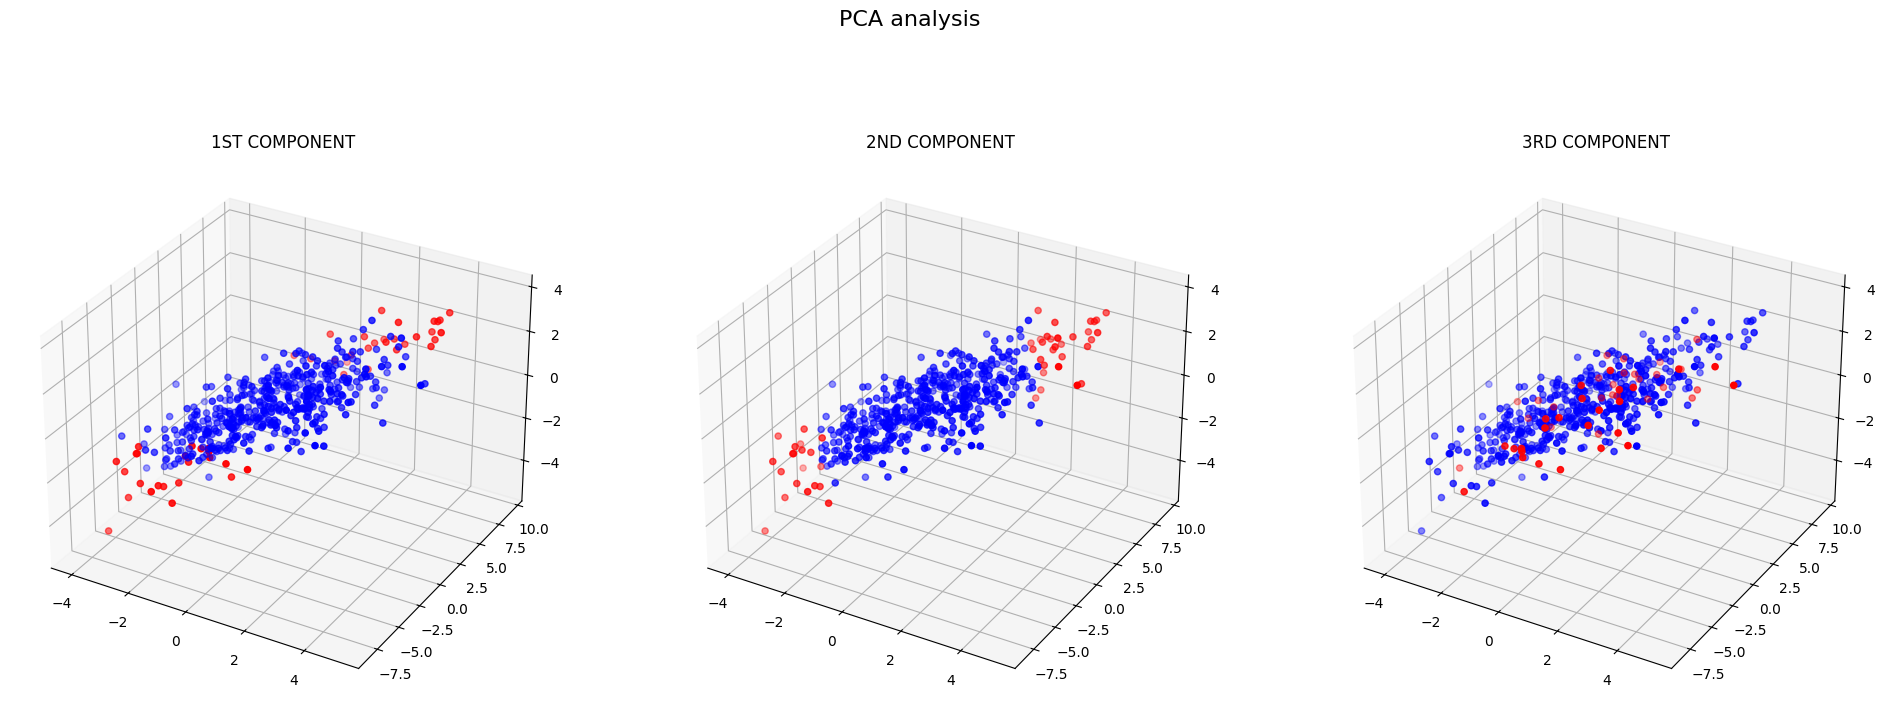

In [ ]:
dataset_on_first_labels = get_labels(dataset, dataset_eigenvectors, component = 0)
dataset_on_second_labels = get_labels(dataset, dataset_eigenvectors, component = 1)
dataset_on_third_labels = get_labels(dataset, dataset_eigenvectors, component = 2)

fig, axs = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={'projection': '3d'})
fig.suptitle("PCA analysis", fontsize=16, y=1.02)

axs[0].scatter(dataset[dataset_on_first_labels == 0][:, 0], dataset[dataset_on_first_labels == 0][:, 1], dataset[dataset_on_first_labels == 0][:, 2], color="blue")
axs[0].scatter(dataset[dataset_on_first_labels == 1][:, 0], dataset[dataset_on_first_labels == 1][:, 1], dataset[dataset_on_first_labels == 1][:, 2], color="red")
axs[0].set_title("1ST COMPONENT")

axs[1].scatter(dataset[dataset_on_second_labels == 0][:, 0], dataset[dataset_on_second_labels == 0][:, 1], dataset[dataset_on_second_labels == 0][:, 2], color="blue")
axs[1].scatter(dataset[dataset_on_second_labels == 1][:, 0], dataset[dataset_on_second_labels == 1][:, 1], dataset[dataset_on_second_labels == 1][:, 2], color="red")
axs[1].set_title("2ND COMPONENT")

axs[2].scatter(dataset[dataset_on_third_labels == 0][:, 0], dataset[dataset_on_third_labels == 0][:, 1], dataset[dataset_on_third_labels == 0][:, 2], color="blue")
axs[2].scatter(dataset[dataset_on_third_labels == 1][:, 0], dataset[dataset_on_third_labels == 1][:, 1], dataset[dataset_on_third_labels == 1][:, 2], color="red")
axs[2].set_title("3RD COMPONENT")

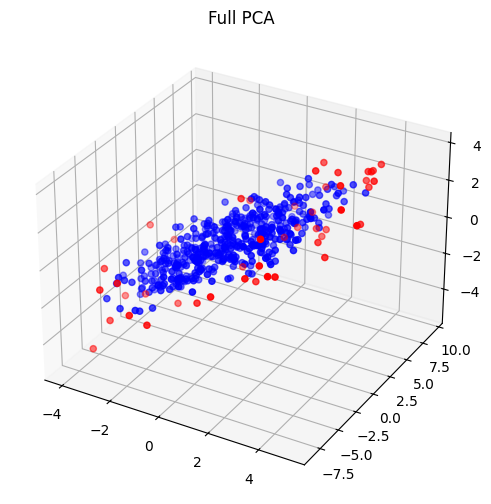

In [ ]:
dataset_proj = dataset @ dataset_eigenvectors

# compute the normalized distances to the centroids
dataset_proj_dists = (dataset_proj - np.mean(dataset_proj, axis=0)) / np.std(dataset_proj, axis=0)
dataset_proj_dists = np.linalg.norm(dataset_proj_dists, axis=1)
# compute the labels
dataset_proj_quantile = np.quantile(dataset_proj, 1 - 0.1)
dataset_proj_labels = np.where(dataset_proj_dists > dataset_proj_quantile, 1, 0)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset[dataset_proj_labels == 0][:, 0], dataset[dataset_proj_labels == 0][:, 1], dataset[dataset_proj_labels == 0][:, 2], color="blue")
ax.scatter(dataset[dataset_proj_labels == 1][:, 0], dataset[dataset_proj_labels == 1][:, 1], dataset[dataset_proj_labels == 1][:, 2], color="red")
ax.set_title("Full PCA")
plt.show()

# **Exercise 2:**

1. In this exercise you will use the shuttle dataset. Split the data in a training set and a testing set (60% of data). Standardize your data and fit a **pyod.models.pca.PCA** model with the training set using the real contamination rate of the training set. Plot the cumulative explained variance
and the individual variances as in the previous exercise (you can access
the variances with the **explained-variance** attribute).

2. Compute the balanced accuracy for both the train and test sets. Then fit
the **pyod.models.kpca.KPCA** model with the same training data and
compute the scores again.

In [ ]:
# unfortunately, the download .mat file does not work,
# thus, the file need to be uploaded manually
!wget https://github.com/VladWero08/AnomalyDetection/blob/main/datasets/shuttle.mat

--2024-12-16 11:08:15--  https://github.com/VladWero08/AnomalyDetection/blob/main/datasets/shuttle.mat
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘shuttle.mat’

shuttle.mat             [  <=>               ] 220.40K  1016KB/s    in 0.2s    

2024-12-16 11:08:16 (1016 KB/s) - ‘shuttle.mat’ saved [225686]



In [ ]:
# load the shuttle dataset
shuttle_dataset = loadmat("shuttle.mat")
shuttle_samples, shuttle_labels = shuttle_dataset["X"], shuttle_dataset["y"]

In [ ]:
# standardize the samples
shuttle_samples = (shuttle_samples - np.mean(shuttle_samples, axis=0)) / np.std(shuttle_samples, axis=0)

In [ ]:
# split the dataset into train and test subsets
shuttle_train_samples, shuttle_test_samples, shuttle_train_labels, shuttle_test_labels = train_test_split(shuttle_samples, shuttle_labels, train_size=0.1)
shuttle_train_contamination = round(np.sum(shuttle_train_labels == 1) / len(shuttle_train_samples), 5)

Text(0.5, 1.0, 'Individual variances')

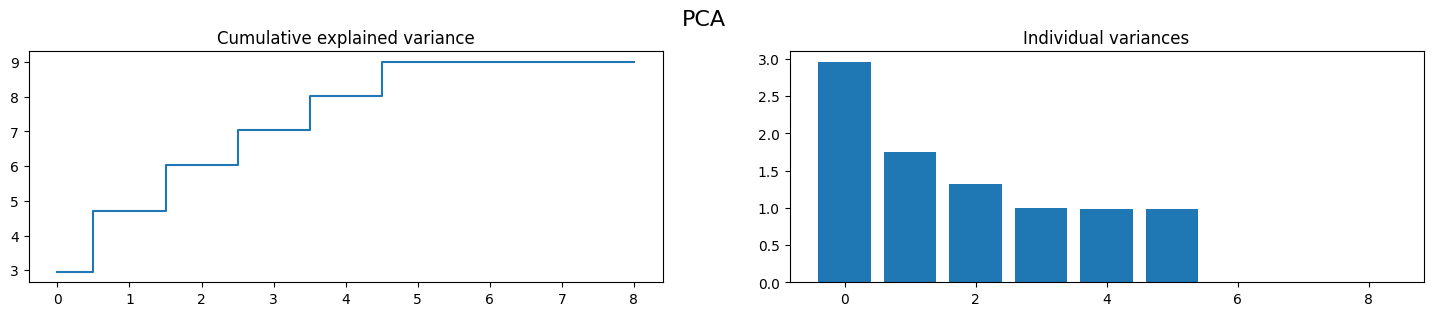

In [ ]:
# define and fit PCA on the train data
pca = PCA(contamination=shuttle_train_contamination)
pca.fit(shuttle_train_samples)

# plot the cumulative variance of each component
# and also the individual variances
fig, axs = plt.subplots(1, 2, figsize=(18, 3))
fig.suptitle("PCA", fontsize=16, y=1.02)

indexes = [i for i in range(len(pca.explained_variance_))]

axs[0].step(range(len(pca.explained_variance_)), np.cumsum(pca.explained_variance_), where="mid")
axs[0].set_title("Cumulative explained variance")

axs[1].bar(range(len(pca.explained_variance_)), pca.explained_variance_)
axs[1].set_title("Individual variances")

In [ ]:
shuttle_train_pca_predictions = pca.predict(shuttle_train_samples)
shuttle_test_pca_predictions = pca.predict(shuttle_test_samples)

shuttle_train_pca_ba = Metrics.balanced_accuracy(shuttle_train_labels, shuttle_train_pca_predictions)
shuttle_test_pca_ba = Metrics.balanced_accuracy(shuttle_test_labels, shuttle_test_pca_predictions)

print(f"Balanced accuracy PCA train: {shuttle_train_pca_ba:.5f}")
print(f"Balanced accuracy PCA test : {shuttle_test_pca_ba:.5}")

Balanced accuracy PCA train: 0.98011
Balanced accuracy PCA test : 0.97318


In [ ]:
# define and fit PCA on the train data
kpca = KPCA(contamination=shuttle_train_contamination, kernel="linear")
kpca.fit(shuttle_train_samples)

KPCA(alpha=1.0, coef0=1, contamination=0.07171, copy_X=True, degree=3,
   eigen_solver='auto', gamma=None, kernel='linear', kernel_params=None,
   max_iter=None, n_components=None, n_jobs=None,
   n_selected_components=None,
   random_state=RandomState(MT19937) at 0x7C12A05C1E40,
   remove_zero_eig=False, sampling=False, subset_size=20, tol=0)

In [ ]:
shuttle_train_kpca_predictions = kpca.predict(shuttle_train_samples)
shuttle_test_kpca_predictions = kpca.predict(shuttle_test_samples)

shuttle_train_kpca_ba = Metrics.balanced_accuracy(shuttle_train_labels, shuttle_train_kpca_predictions)
shuttle_test_kpca_ba = Metrics.balanced_accuracy(shuttle_test_labels, shuttle_test_kpca_predictions)

print(f"Balanced accuracy KPCA train: {shuttle_train_kpca_ba:.5f}")
print(f"Balanced accuracy KPCA test : {shuttle_test_kpca_ba:.5}")

Balanced accuracy KPCA train: 0.71899
Balanced accuracy KPCA test : 0.71783


# **Exercise 3:**

1. In this exercise you will use the shuttle dataset from ODDS. Load the data
using **scipy.io.loadmat()** and use **train_test_split()** to split it into train and test subsets (use 50% of data for testing). Use min-max normalization
to bring your train data in the [0-1] range.

2. Design an Autoencoder class that subclasses **keras.Model**. Use the **keras.Sequential** model to create encoder and decoder submodels that
contain only **keras.layers.Dense** layers. The 2 submodels should contain layers with [8, 5, 3] and [5, 8, 9] output units. Use relu activation
function for each layer except the last one (from the decoder), which will
use **sigmoid** activation.

3. Compile your model using **adam** optimizer and **mse** loss and fit it with
your training data using **100 epochs** and a batch size of **1024** (use the
test data as validation data in the trainig process). Plot the training and
validation loss.

4. In order to obtain the scores for the training data pass it through the
autoencoder and get the reconstruction error for each sample. Compute
a threshold that will be used to classify data with the **numpy.quantile**
function and the contamination rate of the dataset. Compute the balanced
accuracy for both the training and testing set.

In [ ]:
# load the shuttle dataset
shuttle_dataset = loadmat("shuttle.mat")
shuttle_samples, shuttle_labels = shuttle_dataset["X"], shuttle_dataset["y"]

In [ ]:
# split the dataset into train and test subsets
shuttle_train_samples, shuttle_test_samples, shuttle_train_labels, shuttle_test_labels = train_test_split(shuttle_samples, shuttle_labels, test_size=0.5)
shuttle_train_contamination = round(np.sum(shuttle_train_labels == 1) / len(shuttle_train_samples), 5)

In [ ]:
max_ = 1
min_ = 0

# min-max normalization
shuttle_train_std = (shuttle_train_samples - np.min(shuttle_train_samples, axis=0)) / (np.max(shuttle_train_samples, axis=0) - np.min(shuttle_train_samples, axis=0))
shuttle_train_samples = shuttle_train_std * (max_ - min_) + min_

shuttle_test_std = (shuttle_test_samples - np.min(shuttle_test_samples, axis=0)) / (np.max(shuttle_test_samples, axis=0) - np.min(shuttle_test_samples, axis=0))
shuttle_test_samples = shuttle_test_std * (max_ - min_) + min_

In [ ]:
class AutoEncoder(keras.Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()

    self.encoder = keras.Sequential([
      layers.Dense(8, activation="relu"),
      layers.Dense(5, activation="relu"),
      layers.Dense(3, activation="relu")
    ])

    self.decoder = keras.Sequential([
      layers.Dense(5, activation="relu"),
      layers.Dense(8, activation="relu"),
      layers.Dense(9, activation="sigmoid")
    ])

  def call(self, x):
    return self.decoder(self.encoder(x))

In [ ]:
autoencoder = AutoEncoder()
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder_hist = autoencoder.fit(
  shuttle_train_samples, shuttle_train_samples,
  epochs=100,
  batch_size=1024,
  validation_data=(shuttle_test_samples, shuttle_test_samples)
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3146 - val_loss: 0.0333
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3084 - val_loss: 0.0311
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3005 - val_loss: 0.0281
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2894 - val_loss: 0.0247
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2727 - val_loss: 0.0229
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2491 - val_loss: 0.0251
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2200 - val_loss: 0.0322
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1925 - val_loss: 0.0391
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1748 - val_loss: 0.0415
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1649 - val_loss: 0.0409
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1583 - val_loss: 0.0407
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

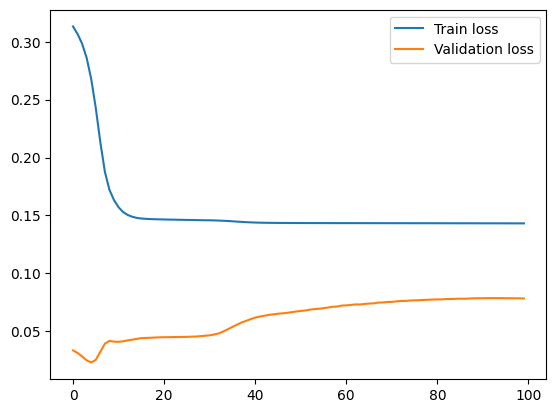

In [ ]:
plt.plot(autoencoder_hist.history["loss"], label="Train loss")
plt.plot(autoencoder_hist.history["val_loss"], label="Validation loss")
plt.legend()
plt.show()

In [ ]:
# take train and test through the network
shuttle_train_reconstruction = autoencoder.predict(shuttle_train_samples)
shuttle_test_reconstruction = autoencoder.predict(shuttle_test_samples)

# compute the errors
shuttle_train_errors = np.sum(np.abs(shuttle_train_samples - shuttle_train_reconstruction), axis=1)
shuttle_test_errors = np.sum(np.abs(shuttle_test_samples - shuttle_test_reconstruction), axis=1)

768/768 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
768/768 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
# create a quantile with the true contamination
# of the training and testing data
shuttle_train_quantile = np.quantile(shuttle_train_errors, 1 - shuttle_train_contamination)
shuttle_test_quantile = np.quantile(shuttle_test_errors, 1 - shuttle_train_contamination)

# compute the predictions
shuttle_train_predictions = np.where(shuttle_train_errors > shuttle_train_quantile, 1, 0)
shuttle_test_predictions = np.where(shuttle_test_errors > shuttle_test_quantile, 1, 0)

In [ ]:
shuttle_train_ae_ba = Metrics.balanced_accuracy(shuttle_train_labels, shuttle_train_predictions)
shuttle_test_ae_ba = Metrics.balanced_accuracy(shuttle_test_labels, shuttle_test_predictions)

print(f"Balanced accuracy AutoEncoder train: {shuttle_train_ae_ba:.5f}")
print(f"Balanced accuracy AutoEncoder test : {shuttle_test_ae_ba:.5}")

Balanced accuracy AutoEncoder train: 0.53476
Balanced accuracy AutoEncoder test : 0.46776


# **Exercise 4:**

1. In this exercise we will use the mnist dataset **from tensorflow.keras.datasets.mnist**. After you load the dataset with **tensorflow.keras.datasets.mnist.load data()** you will normalize it by dividing with 255. In order to simulate anomalies, you will add some noise to the images with **tensorflow.random.normal**
(multiplied by a factor of 0.35). You will use **tensorflow.clip_by_value**
to keep the range of the pixels [0, 1].

2. Design a Convolutional Autoencoder class that uses the **keras.Sequential**
model to create encoder and decoder submodels that contain **keras.layers.Conv2D** and **keras.layers.Conv2DTranspose** layers. The encoder will contain:

- 1 **Conv2D** layer with 8 (3 X 3) filters, relu activation, strides=2 and
padding - ’same’

- 1 **Conv2D** layer with 4 (3 X 3) filters and the rest of params as
above

Decoder:

- 1 **Conv2DTranspose** layer with the same parameters as the last
layer of the encoder
- 1 **Conv2DTranspose** layer with the same parameters as the first
layer of the encoder
- 1 **Conv2D** layer with 1 filter with sigmoid activation that will reconstruct the original image


3. Compile your model using **adam** optimizer and **mse** loss and fit it with
your training data using 10 epochs and a batch size of 64 (use the test
data as validation data in the trainig process). Use only the original
train data for training. Compute the reconstruction loss for the training
data and a threshold (that will be the mean of the reconstruction errors
and their standard deviation). Based on the threshold and the obtained
reconstruction errors classify both the original test images and the ones
that have the added noise (and compute the corresponding accuracy).

4. Plot in the same figure, on four rows, 5 test images: on the first row -
the original ones, on the second one - the images with the added noise, on
the third, the reconstructed images obtained from the original ones and
on the last row the reconstructed images obtained from the images with
added noise.

5. Modify the training stage in order to obtain a Denoising Autoencoder and
print the same figure again.

In [26]:
# load the mnist data set from keras
(mnist_train_data, mnist_train_labels), (mnist_test_data, mnist_test_labels) = keras.datasets.mnist.load_data()

# normalize the pixel's value
mnist_train_data = mnist_train_data / 255
mnist_test_data = mnist_test_data / 255

# clip the new values so pixel are inside [0, 1]
mnist_train_data_noisy = tf.clip_by_value(mnist_train_data + tf.random.normal(mnist_train_data.shape) * 0.35, 0, 1)
mnist_test_data_noisy = tf.clip_by_value(mnist_test_data + tf.random.normal(mnist_test_data.shape) * 0.35, 0, 1)

In [27]:
class ConvAutoEncoder(keras.Model):
  def __init__(self):
    super(ConvAutoEncoder, self).__init__()

    self.encoder = keras.Sequential([
        layers.InputLayer(shape=(28, 28, 1)),
        layers.Conv2D(filters=8, kernel_size=(3, 3), activation="relu", strides=2, padding="same"),
        layers.Conv2D(filters=4, kernel_size=(3, 3), activation="relu", strides=2, padding="same")
    ])

    self.decoder = keras.Sequential([
        layers.Conv2DTranspose(filters=4, kernel_size=(3, 3), activation="relu", strides=2, padding="same"),
        layers.Conv2DTranspose(filters=8, kernel_size=(3, 3), activation="relu", strides=2, padding="same"),
        layers.Conv2D(filters=1, kernel_size=(3, 3), activation="sigmoid", padding="same")
    ])

    self.auto_encoder = keras.Sequential([self.encoder, self.decoder])

  def call(self, image):
    return self.auto_encoder(image)

In [28]:
# add a new dimension to the data, which represent the color channel
mnist_train_data = np.expand_dims(mnist_train_data, axis=3)
mnist_train_data_noisy = np.expand_dims(mnist_train_data_noisy, axis=3)
mnist_test_data = np.expand_dims(mnist_test_data, axis=3)
mnist_test_data_noisy = np.expand_dims(mnist_test_data_noisy, axis=3)

In [22]:
conv_autoencoder = ConvAutoEncoder()
conv_autoencoder.compile(optimizer="adam", loss="mse")
conv_autoencoder_hist = conv_autoencoder.fit(
  mnist_train_data, mnist_train_data,
  epochs=10,
  batch_size=64,
  validation_data=(mnist_test_data, mnist_test_data)
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - loss: 0.0825 - val_loss: 0.0063
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 57s 61ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 62s 39ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step - loss: 0.0035 - val_loss: 0.0033


In [23]:
# compute predictions and residual errors on train
mnist_train_reconstructions = conv_autoencoder(mnist_train_data)
mnist_train_errors = np.sum(np.abs(mnist_train_reconstructions - mnist_train_data), axis=(1, 2))
mnist_train_threshold = np.mean(mnist_train_errors) + np.std(mnist_train_errors)

In [24]:
# compute predictions and residual errors on test
mnist_test_reconstructions = conv_autoencoder(mnist_test_data)
mnist_test_errors = np.sum(np.abs(mnist_test_reconstructions - mnist_test_data), axis=(1, 2))
mnist_test_predictions = np.where(mnist_test_errors > mnist_train_threshold, 1, 0)

# compute predictions and residual errors on noisy test
mnist_test_noisy_reconstructions = conv_autoencoder(mnist_test_data_noisy)
mnist_test_noisy_errors = np.sum(np.abs(mnist_test_noisy_reconstructions - mnist_test_data_noisy), axis=(1, 2))
mnist_test_noisy_predictions = np.where(mnist_test_noisy_errors > mnist_train_threshold, 1, 0)

test_ba = Metrics.balanced_accuracy(mnist_test_predictions, mnist_test_noisy_predictions)
print(f"BA between normal and noisy test images: {test_ba:.5f}")

BA between normal and noisy test images: 0.50000


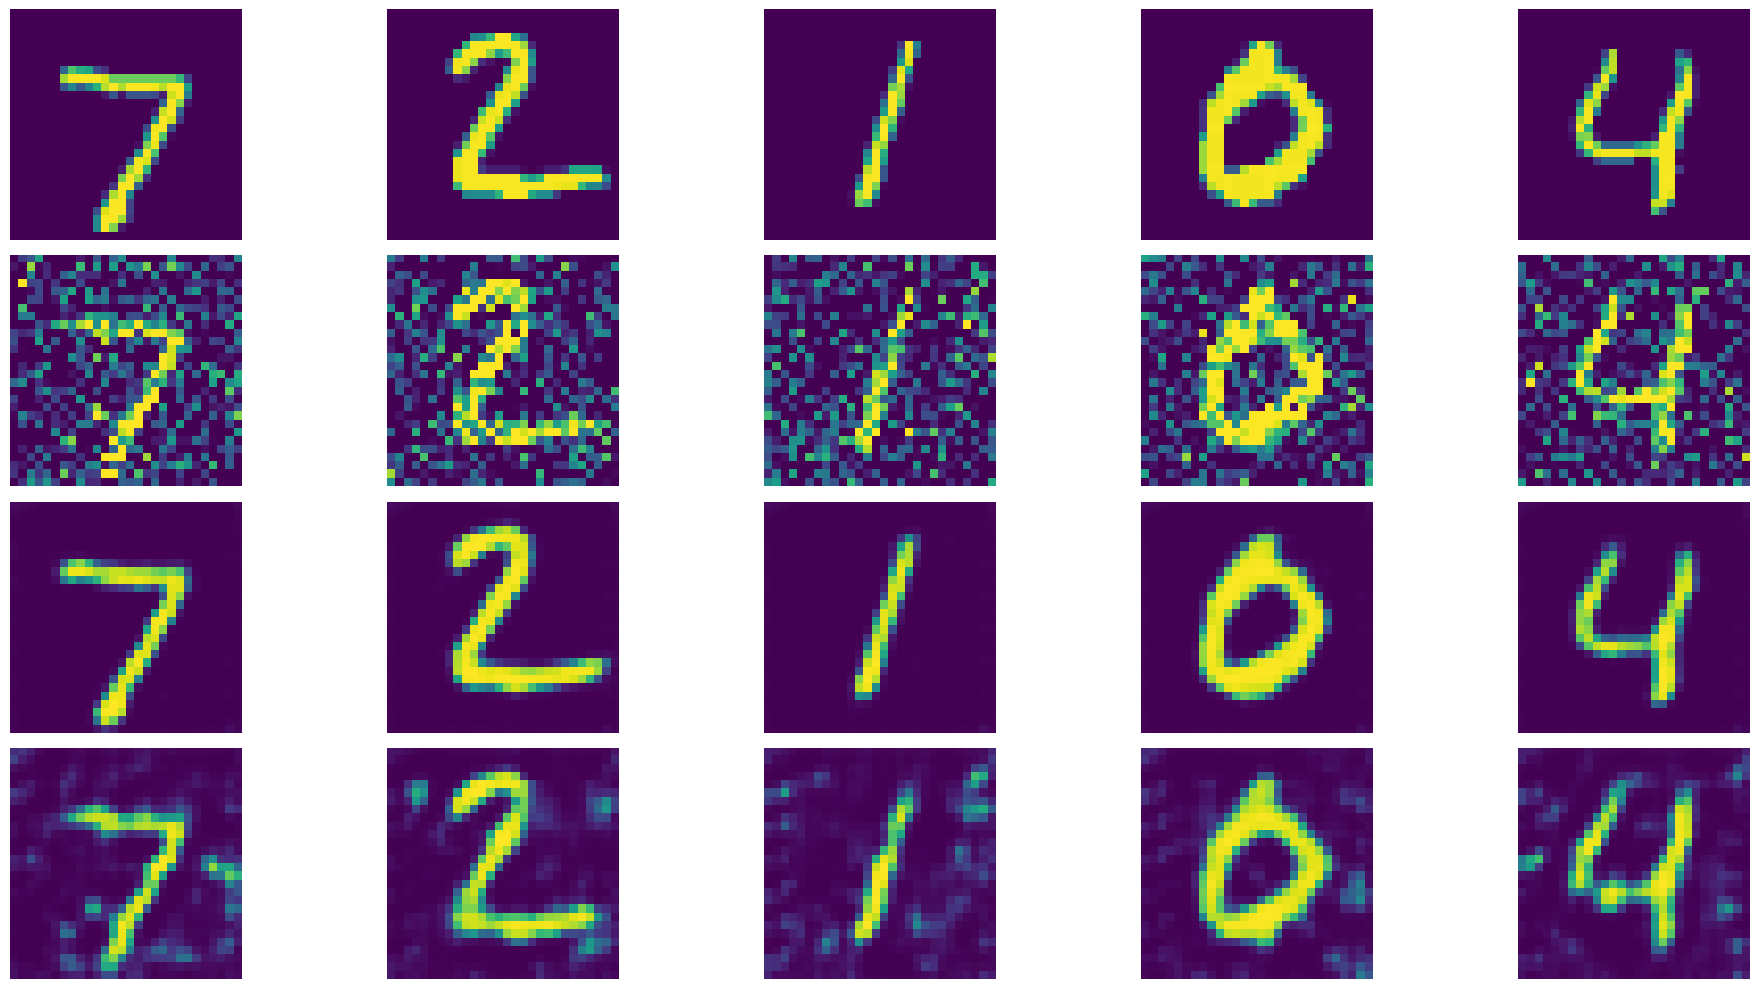

In [25]:
images = np.vstack([
    mnist_test_data[:5],
    mnist_test_data_noisy[:5],
    mnist_test_reconstructions[:5],
    mnist_test_noisy_reconstructions[:5]
])

images = images.squeeze()

fig, axes = plt.subplots(4, 5, figsize=(20, 10))

for i in range(4):
    for j in range(5):
        axes[i, j].axis("off")
        axes[i, j].imshow(images[i * 5 + j])

plt.tight_layout()
plt.show()

In [30]:
# in order to create a denoising auto encoder,
# the train should be done on noisy images, and the
# scoring should be done on the original images
denoising_auto_encoder = ConvAutoEncoder()
denoising_auto_encoder.compile(optimizer="adam", loss="mse")
denoising_auto_encoder_hist = denoising_auto_encoder.fit(
  mnist_train_data_noisy, mnist_train_data,
  epochs=10,
  batch_size=64,
  validation_data=(mnist_test_data_noisy, mnist_test_data)
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 101s 54ms/step - loss: 0.1323 - val_loss: 0.1140
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - loss: 0.1120 - val_loss: 0.1140


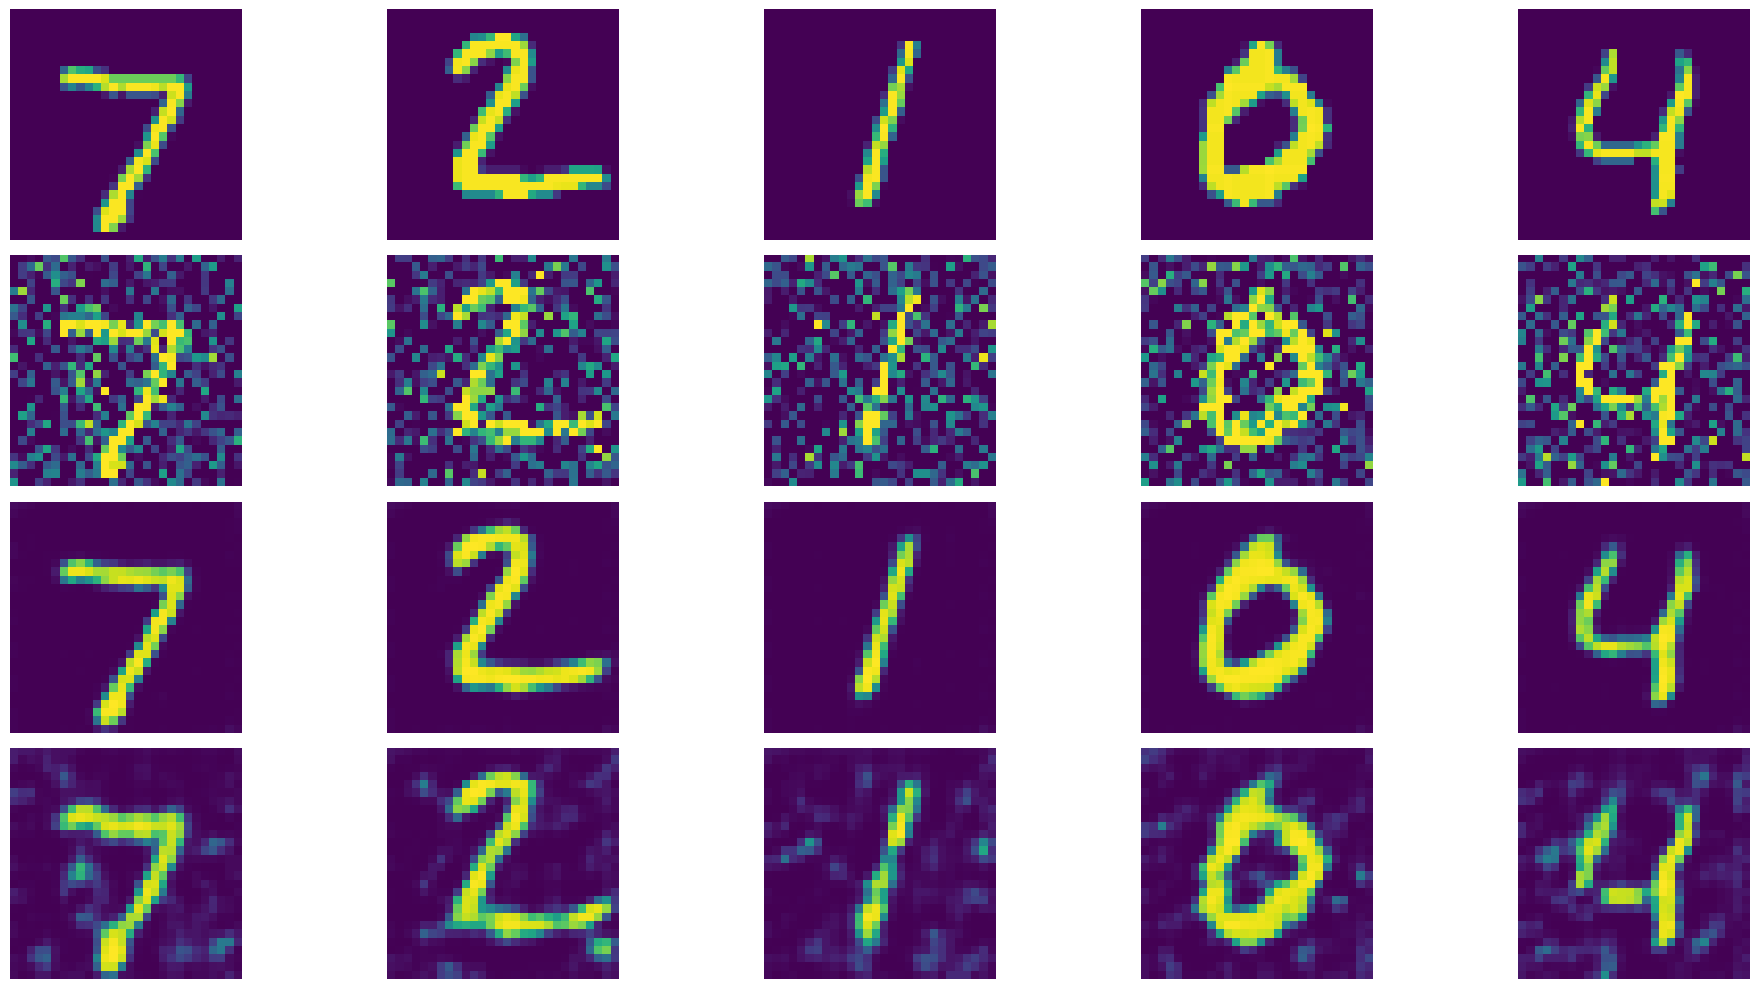

In [31]:
# compute the test reconstructions
mnist_test_reconstructions_dae = conv_autoencoder(mnist_test_data)
# compute the noisy test reconstructions
mnist_test_noisy_reconstructions_dae = conv_autoencoder(mnist_test_data_noisy)

images = np.vstack([
    mnist_test_data[:5],
    mnist_test_data_noisy[:5],
    mnist_test_reconstructions_dae[:5],
    mnist_test_noisy_reconstructions_dae[:5]
])

images = images.squeeze()

fig, axes = plt.subplots(4, 5, figsize=(20, 10))

for i in range(4):
    for j in range(5):
        axes[i, j].axis("off")
        axes[i, j].imshow(images[i * 5 + j])

plt.tight_layout()
plt.show()